# Computational Game Theory Group Assignment: Evolutionary Dynamics  of N-person Hawk-Dove games
Sam Vanspringel - 0580462 - VUB

Hendrik Temmerman - 0568045 - VUB

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import egttools as egt
import nashpy as nash
import scipy
from scipy.special import comb

from egttools.plotting.helpers import (
    xy_to_barycentric_coordinates, calculate_stationary_points, calculate_stability
)
from egttools.helpers.vectorized import (
    vectorized_replicator_equation, vectorized_barycentric_to_xy_coordinates
)

from egttools.plotting import Simplex2D

from egttools.analytical import replicator_equation_n_player
from egttools.analytical.utils import (calculate_gradients, find_roots, check_replicator_stability_pairwise_games,)
from egttools.plotting import plot_gradients
from pprint import pprint

In [17]:
nb_strategies = 2

# 1. Infinite Populations

In [18]:
# define the parameters
R = 1.0
N = 5

#n_hawks = np.random.randint(0, N)
#n_doves = N - n_hawks

#x_hawks = n_hawks/N
#x_doves = 1-x_hawks

n_steps = 100

In [19]:
# Payoff hawks
def P_H(amount_hawks, c_h):
    P_H = 0
    total_hawks = amount_hawks + 1
    if total_hawks > 0:
        P_H = (R - amount_hawks*c_h) / total_hawks
    return P_H

# Payoff doves
def P_D(amount_hawks):
    if amount_hawks == 0:
        P_D = R/N
    elif amount_hawks > 0:
        P_D = 0.0
    return P_D



In [20]:
# Fitness hawks
def average_fitness_hawks(N, x_fraction, c_h):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H(i, c_h)
    return average_fitness
    
# Fitness doves
def average_fitness_doves(N, x_fraction):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D(i+1)
    return average_fitness

# Fitness average
def average_fitness_population(x_hawks, x_doves, fitness_hawks, fitness_doves):
    return (x_hawks * fitness_hawks) + (x_doves * fitness_doves)
    


In [21]:
#Experiment (Figure: 1.A)

c_h_results = np.empty((3, n_steps))
dove_densities = np.linspace(0, 1, num=n_steps, dtype=np.float64)

for index, c_h in enumerate([0.1, 0.5, 0.9]):
    
    x_dot = np.empty(n_steps)

    for i in range(len(dove_densities)):
        x = dove_densities[i]
        fitness_doves = average_fitness_doves(N, x)
        fitness_hawks = average_fitness_hawks(N, 1-x, c_h)

        x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)
        
    c_h_results[index] = x_dot


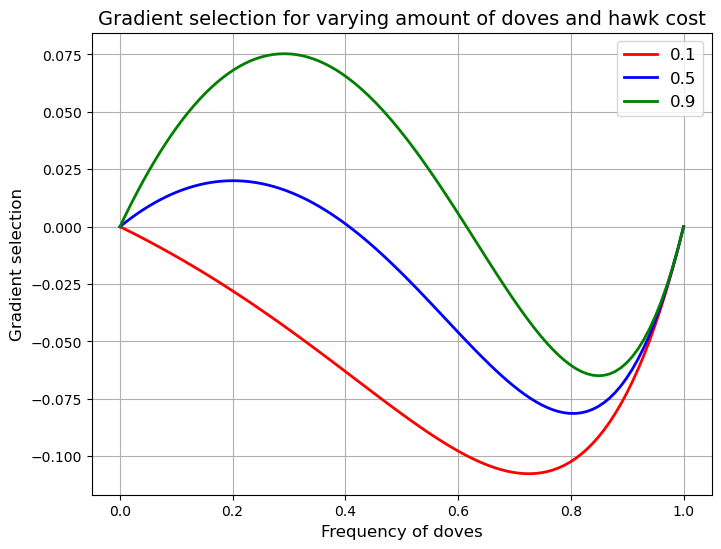

In [22]:
#Plotting
labels = ["0.1", "0.5", "0.9"]
colors = ["red", "blue", "green"]

# Plot each array
plt.figure(figsize=(8, 6))
for i, values in enumerate(c_h_results):
    plt.plot(dove_densities, values, label=labels[i], color=colors[i], linewidth=2)

# Add labels, legend, and grid
plt.xlabel("Frequency of doves", fontsize=12)
plt.ylabel("Gradient selection", fontsize=12)
plt.title("Gradient selection for varying amount of doves and hawk cost", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [23]:
def find_equilibria_indexes(run):
    eq = []
    for i in range(run.shape[0]):
        gradient = run[i]
        if gradient == 0.0:
            eq.append(i)
        if i < len(run):
            if run[i] < 0 and run[i + 1] > 0:
                    eq.append(i)
            if run[i] > 0 and run[i + 1] < 0:
                    eq.append(i)
    return eq


dove_densities = np.linspace(0, 1, num=n_steps, dtype=np.float64)
N_values = [5,10,20,50,100]
eq_results =  np.empty((len(N_values), n_steps))

for i_N, N in enumerate(N_values):
    eq = []
    for index, c_h in enumerate(np.linspace(0, 1, num=n_steps, dtype=np.float64)):
        
        x_dot = np.empty(n_steps)

        for i in range(len(dove_densities)):
            x = dove_densities[i]
            fitness_doves = average_fitness_doves(N, x)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h)

            x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

        equilibria = find_equilibria_indexes(x_dot)  
        
        if len(equilibria) > 2:
            eq.append(dove_densities[equilibria[1]])
        else: 
            eq.append(dove_densities[equilibria[0]])

    eq_results[i_N] = eq

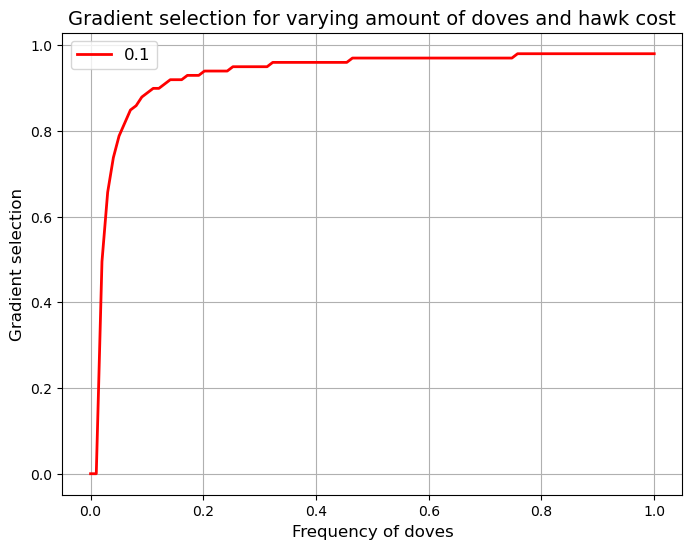

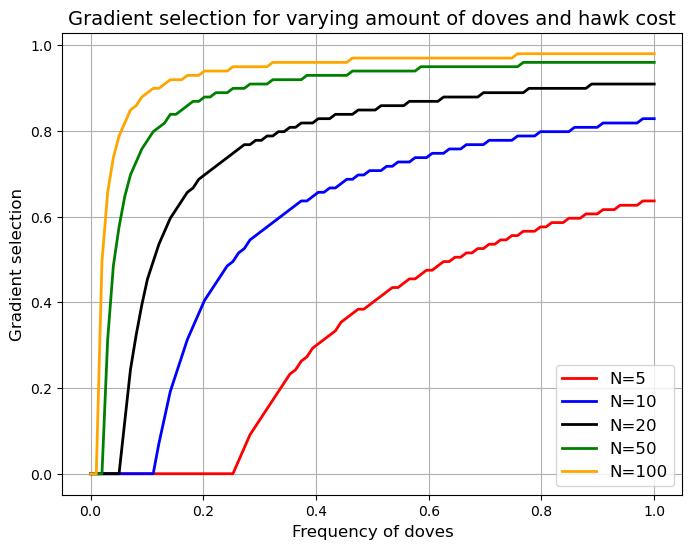

In [ ]:

#Plotting
labels = ["N=5", "N=10", "N=20", "N=50", "N=100"]
colors = ["red", "blue", "black", "green", "orange"]

# Plot each array
plt.figure(figsize=(8, 6))
for i, values in enumerate(eq_results):
    plt.plot(dove_densities, values, label=labels[i], color=colors[i], linewidth=2)

# Add labels, legend, and grid
plt.xlabel("Frequency of doves", fontsize=12)
plt.ylabel("Gradient selection", fontsize=12)
plt.title("Gradient selection for varying amount of doves and hawk cost", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
#Experiment (Figure: 1.B)

N_values = [5,10,20,50,100]
c_h_values = np.linspace(0, 1, num=n_steps, dtype=np.float64)
equilibrium_frequencies = np.empty(len(N_values), dtype=object)


for idx_N, N in enumerate(N_values):
    equilibria_for_cost = []

    for c_h in c_h_values:

        def fitness_diff(x):
            f_hawks = (R - c_h * (1 - x)) / (1 - x) if x < 1 else 0
            f_doves = R * x / N
            return f_hawks - f_doves

        # Find the equilibrium x_star numerically
        x_star = scipy.optimize.bisect(fitness_diff, 0, 1, xtol=1e-6)
        equilibria_for_cost.append(x_star)

    equilibrium_frequencies[idx_N] = np.array(equilibria_for_cost)


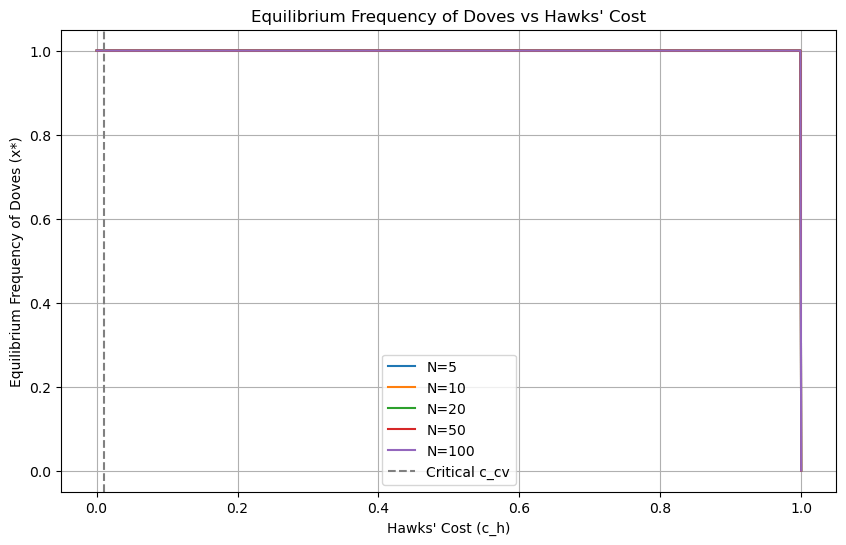

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))

for idx_N, N in enumerate(N_values):
    plt.plot(c_h_values, equilibrium_frequencies[idx_N], label=f'N={N}')

plt.axvline(x=1 / (N - 1), color='gray', linestyle='--', label='Critical c_cv')
plt.title('Equilibrium Frequency of Doves vs Hawks\' Cost')
plt.xlabel('Hawks\' Cost (c_h)')
plt.ylabel('Equilibrium Frequency of Doves (x*)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Parameters
R = 1  
N = 5
c_H_values = [0.1, 0.5]  
Z_values = [10, 20, 100]  
w = 1  

In [ ]:
def gradient_of_selection(k, Z, c_H, N, w):

    fraction = k/Z
    f_d = average_fitness_doves(N, fraction)
    f_h = average_fitness_hawks(N, (1-fraction), c_H)

    T_plus = fraction * ((Z - k) / Z) * (1 / (1 + np.exp(-w * (f_d - f_h))))
    T_minus = fraction * ((Z - k) / Z) * (1 / (1 + np.exp(-w * (f_h - f_d))))

    gradient = T_plus - T_minus
    return gradient

def calculate_gradients_figure_2A(Z, c_H, N, w):
    
    k_values = np.arange(Z + 1)
    g_values = np.empty(len(k_values))
    
    for i, k in enumerate(k_values):
        g_values[i] = gradient_of_selection(k, Z, c_H, N, w)

    X_as = k_values / Z
    
    return X_as, g_values

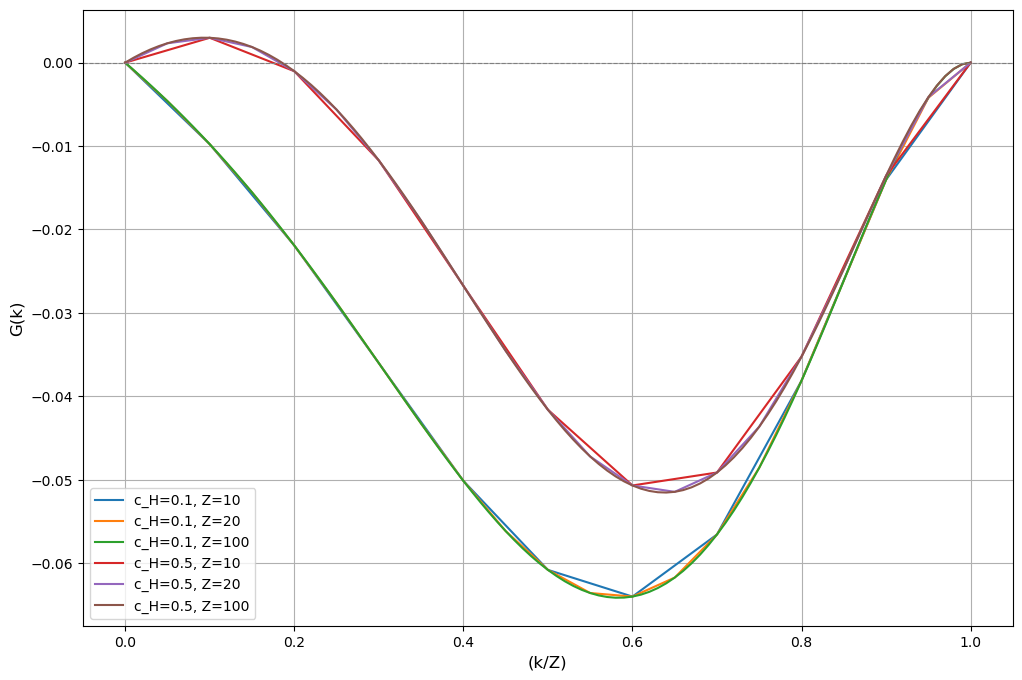

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

for c_H in c_H_values:
    for Z in Z_values:
        X_as, g_values = calculate_gradients_figure_2A(Z, c_H, N, w)
        ax.plot(X_as, g_values, label=f"c_H={c_H}, Z={Z}")

# Plot details
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_xlabel("(k/Z)", fontsize=12)
ax.set_ylabel("G(k)", fontsize=12)
ax.legend()
ax.grid()
plt.show()

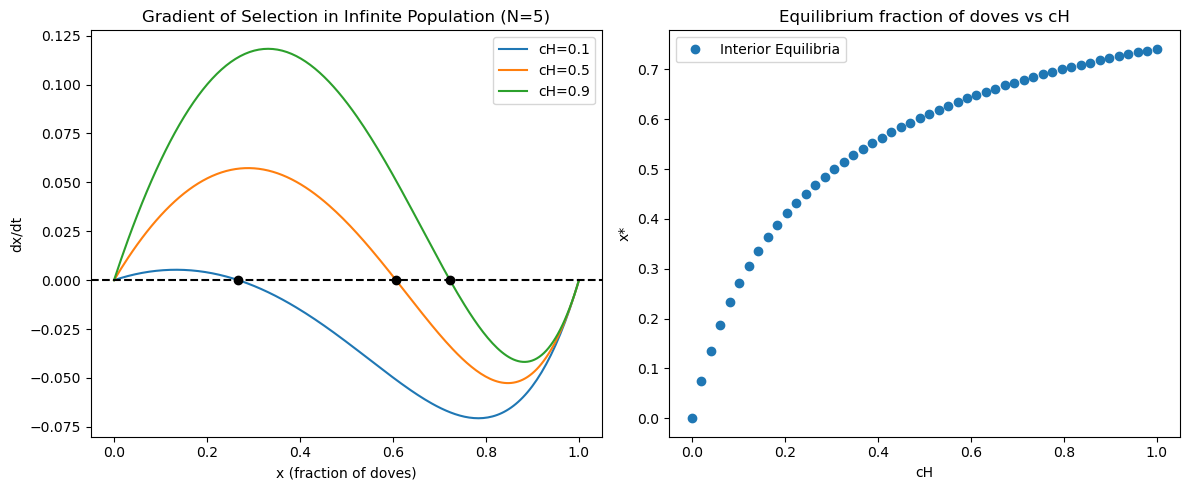

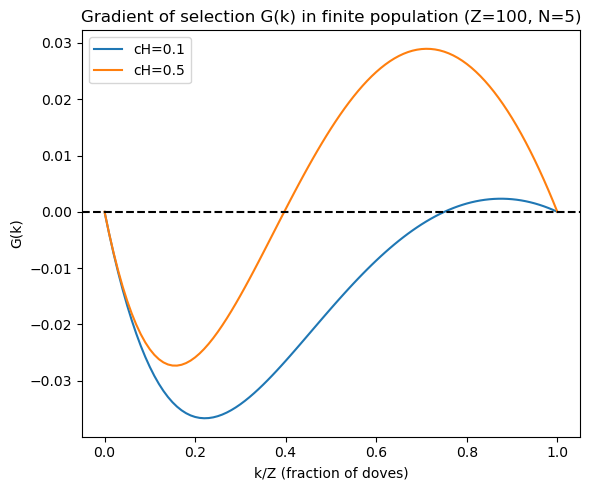